In [51]:
import os

base_directory = '../data/output'


def load_generation_file(generation):
    generation_file_path = f"{base_directory}/{str(generation)}"
    
    if not os.path.isfile(generation_file_path):
        return None
    
    generation_file = open(generation_file_path, 'r')
    return generation_file


def load_all_generation_files():
    generation_files = []
    current_generation = 0
    
    while True:
        generation_file = load_generation_file(current_generation)
        
        if generation_file is None:
            break
        
        generation_files.append(generation_file)
        current_generation += 1
        
    return generation_files 

In [52]:
import networkx as nx

def parse_graph(generation_file):
    G = nx.DiGraph()
    
    is_directed = True

    for line in generation_file:
        if '% undirected\n' == line:
            is_directed = False
            continue
        
        if '%' in line:
            continue
        
        u, v, weight = line.split()
        G.add_node(u)
        G.add_node(v)
        
        print(u, v, weight)
        
        G.add_edge(u, v, weight=weight)
        
        if not is_directed:
            G.add_edge(v, u, weight=weight)

    return G

def get_degrees(graph, use_in_degree=True):
    # Get the degrees depending on the use_in_degree parameter
    degrees = graph.in_degree() if use_in_degree else graph.out_degree()
    
    # Convert the degrees to a list of (int id, int degree) tuples
    vertex_degrees_pair_list = [(int(id), degree) for id, degree in degrees]

    # Use a dictionary to map the vertex id to the vertex degree
    vertex_degrees_dict = {}
    for vertex_degrees_pair in vertex_degrees_pair_list:
        vertex_id = vertex_degrees_pair[0]
        vertex_degree = vertex_degrees_pair[1]
        vertex_degrees_dict[vertex_id] = vertex_degree
    
    # Return a list of (int id, int degree) tuples ordered by the vertex id
    # We use the max vertex id to make sure we have all the vertices. 
    # Vertices with degree 0 will now be present due to the mapping.
    return [vertex_degrees_dict.get(vertex_id, 0) for vertex_id in range(0, max(vertex_degrees_dict.keys()) + 1)]

def get_normalized_vertex_sizes(degrees, scale_factor):
    num_vertices = len(degrees)
    max_degree = max(degrees)
    
    normalized_vertex_sizes = []
    
    for degree in degrees:
        min_vertex_size = scale_factor / 10
        normalized_vertex_size = (degree / max_degree) * scale_factor
        normalized_vertex_size = max(min_vertex_size, normalized_vertex_size)
        normalized_vertex_sizes.append(normalized_vertex_size)
        
    return normalized_vertex_sizes

In [53]:
def print_normalized_vertex_sizes(in_degrees, out_degrees, normalized_vertex_sizes):    
    if len(in_degrees) != len(out_degrees) and len(out_degrees) != len(normalized_vertex_sizes):
        raise Exception('The number of in degrees, out degrees, and normalized vertex sizes must be the same')
    
    print("There is something weird going on with the node size and color scaling..\n")
    print('Vertex ID\tIn Degree\tOut Degree\tNormalized Vertex Size')
    
    for i in range(0, len(in_degrees)):
        print(f'{i}\t\t{in_degrees[i]}\t\t{out_degrees[i]}\t\t{int(normalized_vertex_sizes[i])}')

In [54]:

import matplotlib.pyplot as plt
import plotly.graph_objects as go
import numpy as np

def plot_graph(graph, in_degrees, out_degrees, scale_factor=4000):
    plt.figure(num=None, figsize=(15,15))
    
    norm_in_node_sizes = get_normalized_vertex_sizes(in_degrees, scale_factor)
    norm_out_node_sizes = get_normalized_vertex_sizes(out_degrees, scale_factor)
    
    norm_node_sizes = [norm_in_node_size + norm_out_node_size for norm_in_node_size, norm_out_node_size in zip(norm_in_node_sizes, norm_out_node_sizes)]
    
    max_norm_node_size = max(norm_node_sizes)
    alpha_scale = [norm_node_size / max_norm_node_size for norm_node_size in norm_node_sizes]
        
    pos = nx.fruchterman_reingold_layout(graph, k=10, iterations=100)

    # print(len(norm_node_sizes), len(alpha_scale), graph.number_of_nodes())
    nx.draw_networkx_nodes(graph, pos, node_size=norm_node_sizes, node_color='blue', alpha=alpha_scale)
    nx.draw_networkx_edges(graph, pos, arrows=True, arrowsize=15, width=1, node_size=norm_node_sizes)
    
    label_pos = nx.draw_networkx_labels(graph, pos)
 
    plt.show()

0 3 1
0 4 1
1 2 1
1 4 1
1 5 1
1 9 1
2 5 1
2 9 1
3 4 1
3 6 1
3 7 1
4 5 1
4 6 1
4 7 1
5 7 1
5 8 1
5 9 1
5 10 1
6 7 1
6 11 1
7 8 1
7 12 1
8 10 1
8 13 1
9 10 1
10 14 1
11 12 1
12 13 1
13 14 1
0 1 1
1 4 1
1 7 1
2 9 1
3 8 1
4 6 1
4 8 1
5 6 1
7 9 1


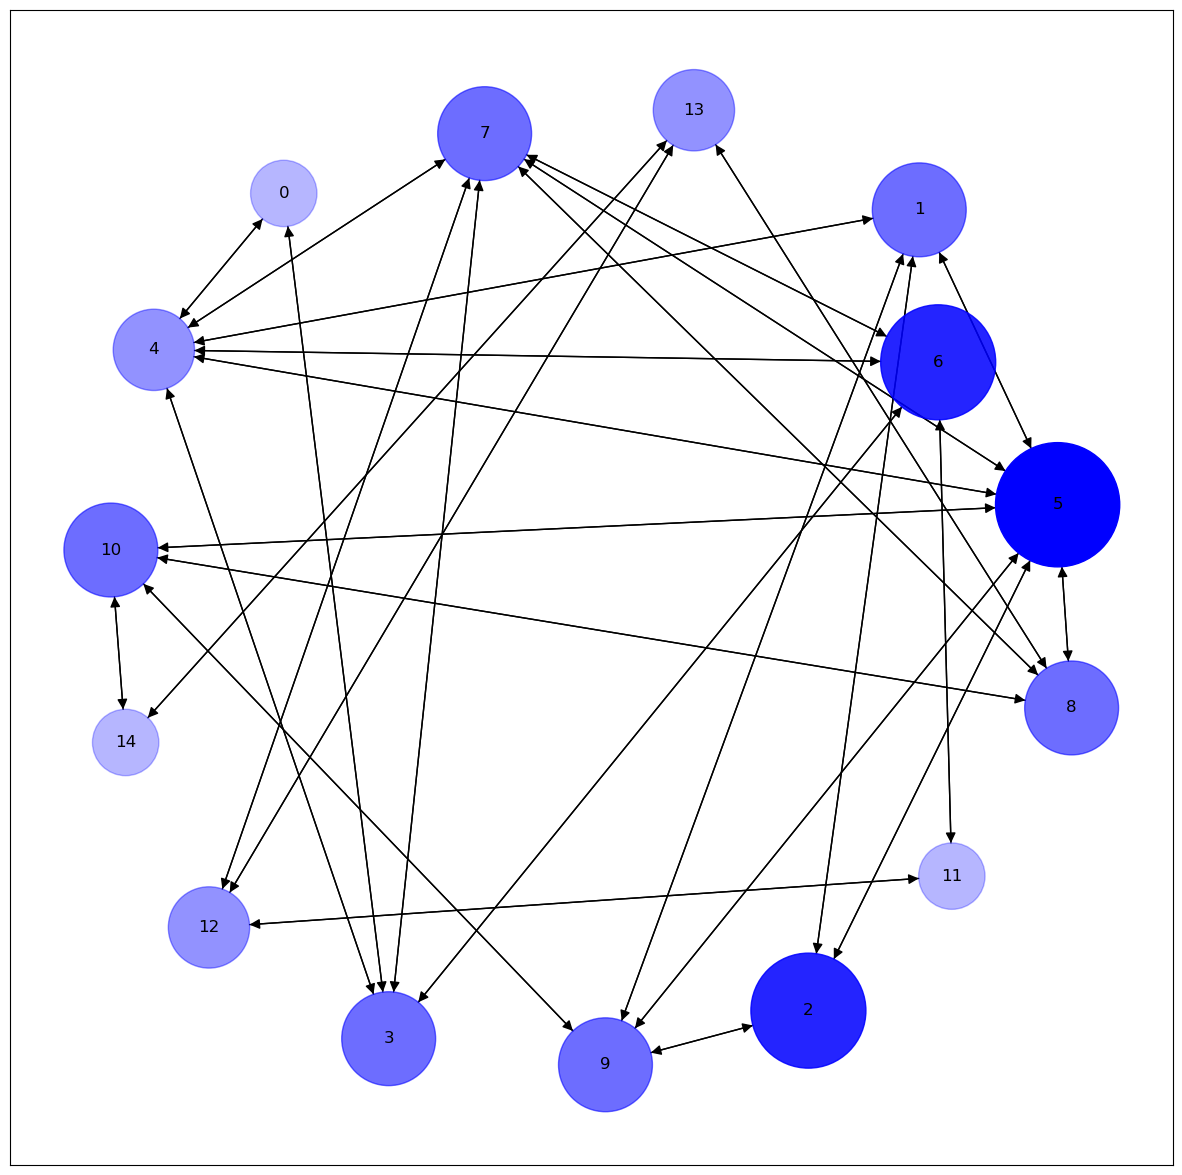

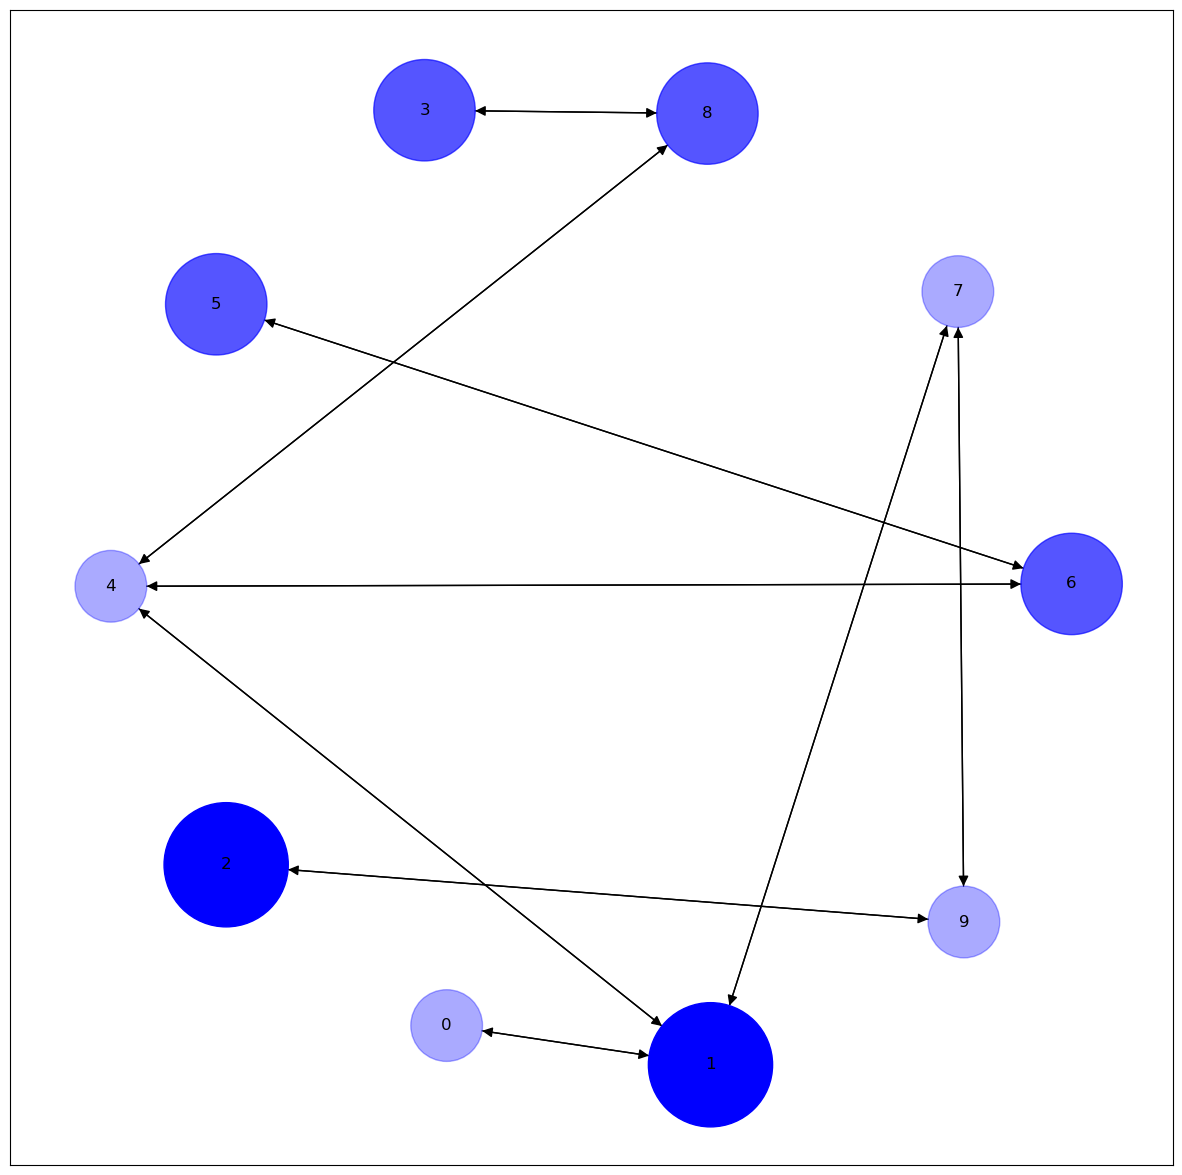

In [55]:
graphs = [parse_graph(generation_file) for generation_file in load_all_generation_files()]
in_degrees = [get_degrees(graph, True) for graph in graphs]
out_degrees = [get_degrees(graph, False) for graph in graphs]

for generation in range(len(graphs)):
    plot_graph(graphs[generation], in_degrees[generation], out_degrees[generation])

# This is causing degrees to get unpacked weirdly in such a way that
# data is lost each time this cell is ran. I am not sure why.
# for graph, degrees in zip(graphs, degrees):
#     plot_graph(graph, degrees)